# PPO algorithm

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.typing import types
from tf_agents.policies import random_py_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import py_policy
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import tf_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network
from tf_agents.agents import PPOAgent
from tf_agents.utils import common as cmn

import matplotlib.pyplot as plt
import qutip
from qutip import sigmap, expect

from tqdm.auto import trange
import random

import sys
sys.path.append('../')
from common.common import get_average_return, extract_double_action_policy

%matplotlib inline

* System parameters

In [9]:
T = 4 # terminal time step
max_steps = 20 # number of time steps
random.seed(1989)

* Create training and evaluation environments and define actions

In [10]:
# validate environment
from environments.qubit_env import QubitContinuousEnv

# define actions
# TODO: actions can be continuous within a range of course 
# actions will be the change in the magnetic field
max_Ω = 1.0
max_Δ = 0.5

environment = QubitContinuousEnv(T, max_steps, max_Ω, max_Δ, fidelity_threshold = 0.99, verbose_fg = False)
eval_environment = QubitContinuousEnv(T, max_steps, max_Ω, max_Δ, fidelity_threshold = 0.99, verbose_fg = False)

train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(eval_environment)

In [11]:
fc_layer_params = (100, 75)
learning_rate = 1e-3
replay_buffer_capacity = 10000
num_iterations = 2000
nb_episodes = 1
eval_interval = 10
checkpoint_dir = "/home/dkoytrom/Msc_Quantum_Computing_Quantum_Technologies/Master_Thesis/algorithms/classical/Reinforcement_learning/checkpoints/ppo_qubit_omega_detuning/"

In [12]:
actor_network = actor_distribution_network.ActorDistributionNetwork(
    input_tensor_spec = train_env.observation_spec(),
    output_tensor_spec = train_env.action_spec(),
    fc_layer_params = fc_layer_params,
    name = "Policy",
)

# use tha Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

train_step_counter = tf.Variable(0)

value_net = value_network.ValueNetwork(
    input_tensor_spec = train_env.observation_spec(),
    fc_layer_params = (100, 50, ),
    name = 'ValueNet'
) 

agent = PPOAgent(
    time_step_spec = train_env.time_step_spec(),
    action_spec = train_env.action_spec(),
    actor_net = actor_network,
    value_net = value_net,
    optimizer = optimizer,
    train_step_counter = train_step_counter,
)

agent.initialize()

In [13]:
# collect trajectories
import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size = replay_buffer_capacity,
    sampler = reverb.selectors.Uniform(),
    remover = reverb.selectors.Fifo(),
    rate_limiter = reverb.rate_limiters.MinSize(1),
    signature = replay_buffer_signature
)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name = table_name,
    sequence_length = None,
    local_server = reverb_server
)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = cmn.function(agent.train)

# Reset the train step.
# agent.train_step_counter.assign(0)

# create a driver which will run the simulations and collect tha dataset for our training
collect_driver = py_driver.PyDriver(
    environment,
    py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function = True),
    observers = [rb_observer],
    max_episodes = nb_episodes
)

# create checkpointer to load training and continue
""" checkpointer = cmn.Checkpointer(
    ckpt_dir = checkpoint_dir,
    max_to_keep = 1,
    agent = agent,
    policy = agent.policy,
    replay_buffer = replay_buffer,
)

checkpointer.initialize_or_restore() """

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmplxascwo1.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmplxascwo1
[reverb/cc/platform/default/server.cc:71] Started replay server on port 44171
[reverb/cc/platform/default/server.cc:84] Shutting down replay server


' checkpointer = cmn.Checkpointer(\n    ckpt_dir = checkpoint_dir,\n    max_to_keep = 1,\n    agent = agent,\n    policy = agent.policy,\n    replay_buffer = replay_buffer,\n)\n\ncheckpointer.initialize_or_restore() '

In [14]:
avg_returns = [get_average_return(eval_env, agent.policy, 10)]

# for _ in range(num_iterations):
with trange(num_iterations, dynamic_ncols = False) as tbar:
    for _ in tbar:
        initial_time_step = environment.reset()
        collect_driver.run(initial_time_step)

        # create dataset from trajectories
        dataset = replay_buffer.as_dataset(sample_batch_size = 1)
        iterator = iter(dataset)

        trajectories , _ = next(iterator)

        # train 
        train_loss = agent.train(experience = trajectories)

        replay_buffer.clear()

        step = agent.train_step_counter.numpy()

        if step % 50 == 0:
            # print('step = {0}: loss = {1}'.format(step, train_loss.loss))
            tbar.set_postfix({"step": step, "loss": train_loss.loss.numpy()})

        if step % eval_interval == 0:
            avg_return = get_average_return(eval_env, agent.policy, 10)
            avg_returns.append(avg_return)


100%|██████████| 2000/2000 [33:02<00:00,  1.01it/s, step=5e+4, loss=-.0237]   


In [15]:
# checkpointer.save(train_step_counter)

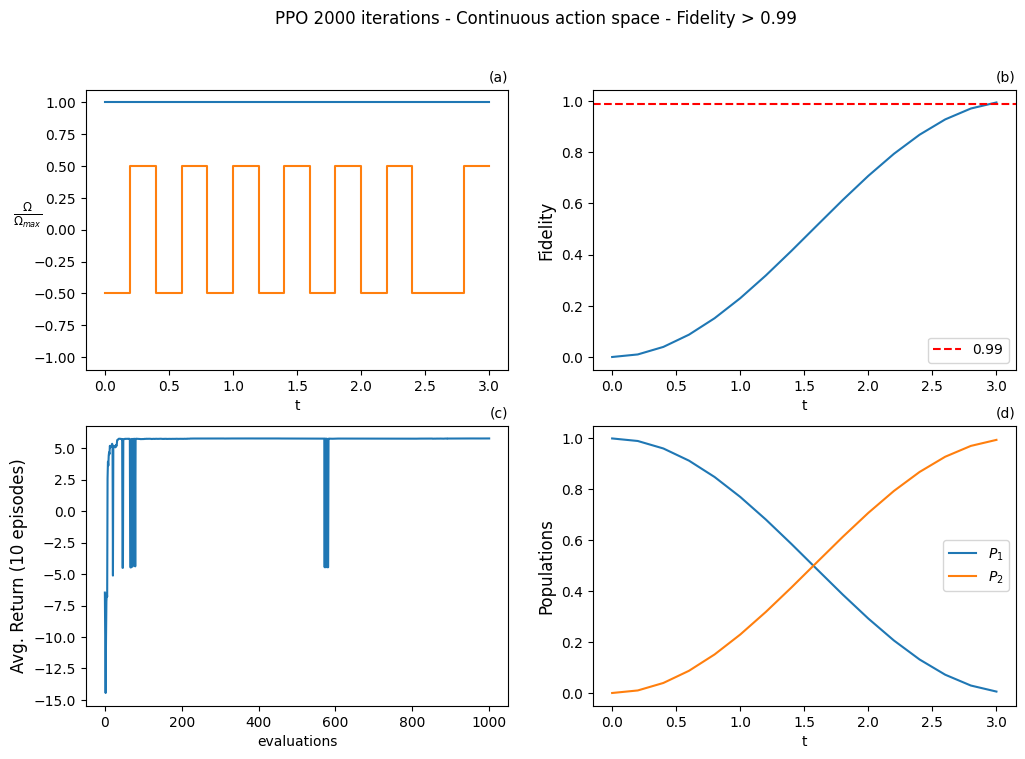

In [16]:
greedy_actions, [optimal_omegas, optimal_detuning], states, fidelities = extract_double_action_policy(environment, agent)

population2 = expect(sigmap().dag() * sigmap(), states)
population1 = 1 - population2

time_span = np.arange(len(optimal_omegas))
time_span = [t * T / max_steps for t in time_span]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)
fig.suptitle(f'PPO {num_iterations} iterations - Continuous action space - Fidelity > 0.99')

ax1.step(time_span, optimal_omegas, where = 'post', label = 'Ω')
ax1.step(time_span, optimal_detuning, where = 'post', label = 'Δ')
ax1.set_ylabel(r"$\frac{\Omega}{\Omega_{max}}$", rotation = 0, fontsize = 12)
ax1.set_ylim((-1.1, 1.1))
ax1.set_xlabel(f"t")
ax1.set_title("(a)", loc = "right", fontsize = 10)

ax2.plot(time_span, fidelities)
ax2.axhline(y = 0.99, color = 'r', linestyle = '--', label = '0.99')
ax2.set_ylabel("Fidelity", rotation = 90, fontsize = 12)
ax2.set_xlabel(f"t")
ax2.legend(loc = 'lower right')
ax2.set_title("(b)", loc = "right", fontsize = 10)

ax4.plot(time_span, population1, label = r"$P_1$")
ax4.plot(time_span, population2, label = r"$P_2$")
ax4.set_ylabel("Populations", rotation = 90, fontsize = 12)
ax4.set_xlabel(f"t")
ax4.set_title("(d)", loc = "right", fontsize = 10)
ax4.legend()

time_span3 = range(len(avg_returns))
ax3.plot(time_span3, avg_returns)
ax3.set_ylabel("Avg. Return (10 episodes)", rotation = 90, fontsize = 12)
ax3.set_xlabel(f"evaluations")
ax3.set_title("(c)", loc = "right", fontsize = 10)

plt.show()